In [1]:
# Group - 14
# Department of Computer Science, University at Buffalo

# Ramanathan Nachiappan - 50469166
# Rakshitha Gowda - 

# PS-2: Sentiment Analysis
# Data Set - IMDB movie reviews - Kaggle
# Biderectional LSTM, GRU

### Loading necessary packages, i.e: PyTorch, NLTK... 

In [2]:
# General packages
import time
import os
from tqdm import tqdm
from torchsummary import summary
from wordcloud import WordCloud
from collections import Counter

# tqdm for diplaying progress during training as we use pytorch
from tqdm import tqdm
tqdm.pandas()

# General packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report

In [3]:
# General packages
import re
import string

# NLTK package for NLP and gensim for Word2vec
import nltk 
from gensim.models import Word2Vec
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

In [4]:
# Downloading stopwords in english using nltk
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Ram
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ram
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# PyTorch for modelling Bi - LSTM, GRU
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as op

### Loading IMDB data from Kaggle and cleaning data - Ramanathan

In [6]:
# Loading Data
file_path = 'C:/Users/Ram N/Desktop/PR project/IMDB Dataset.csv'
dataset = pd.read_csv(file_path)
print(dataset.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
# Finding Duplicates
duplicatedrows = dataset.duplicated().sum()
print("The number of duplications:", duplicatedrows)

The number of duplications: 418


In [9]:
# Removing Duplicates
dataset = dataset.drop_duplicates()

In [10]:
sentiment_counts = dataset['sentiment'].value_counts()
print(sentiment_counts)

positive    24884
negative    24698
Name: sentiment, dtype: int64


###  Data Cleaning text  pipeline - Ramanathan

In [11]:
def stripofimonji(input):
    combiofemonji = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"
                           u'\U00002702-\U000027B0'
                           "]+", flags = re.UNICODE)
    return combiofemonji.sub(r'', input)
def stripnewline(input):
    ct = ' '.join(input.splitlines())
    ct = re.sub(r'(.)\1+', r'\1\1', ct)
    return ct
def striplinks(input):
    ct = re.sub(r'https?://\S+|www\.\S+', '', input)
    ct = re.sub(r'<[^>]+>', '', ct)
    return ct
def stripNonASCII (input):
    return re.sub(r'[^\x00-\x7f]', r'', input)
def stripsymbols(input):
    ct = ''.join(verb for verb in input if verb not in string.punctuation)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', ct)
def striphastags(input): 
    ct = re.sub(r'(?<!\bhashtag)#\w+', '', input) 
    hashes = re.split(r'#[\w-]+|_', ct)
    ct = ' '.join(word.strip() for word in hashes)
    return ct
def stripspacesunwanted(input):
    ct = ' '.join(input.split())
    ct = re.sub(r' +', ' ', ct)
    return re.sub(r'\d+', '', ct)

In [12]:
# Driver Function to clean the reviews
def textcleanline(input):
    input = stripofimonji(input)
    input = stripnewline(input)
    input = striplinks(input)
    input = stripNonASCII(input)
    input = stripsymbols(input)
    input = striphastags(input)
    input = stripspacesunwanted(input)
    return input

In [13]:
dataset['cleanedText'] = dataset['review'].progress_apply(textcleanline)

100%|██████████████████████████████████████████████████████████████████████████| 49582/49582 [00:19<00:00, 2528.04it/s]


###  NLP pre processing  pipeline and word Embedding(word2vec)- Ramanathan

In [14]:
# we used tokinization and stopword removal with lematization to bring important individual words to its cannoniacal form
def stopwordremoval(input):
    return [j for j in input if j not in stopwords]
def lemmatization(input):
    return [WordNetLemmatizer().lemmatize(k) for k in input]
def tokenizer(input):
    return word_tokenize(input)

In [15]:
# Driver Function to NLP preprocess the reviews
def NLPpreprocess(input):
    hens = tokenizer(input)
    removed = stopwordremoval(hens)
    le = lemmatization(removed)
    return ' '.join(le)

In [16]:
dataset['processed'] = dataset['cleanedText'].progress_apply(NLPpreprocess)

100%|███████████████████████████████████████████████████████████████████████████| 49582/49582 [00:50<00:00, 981.55it/s]


In [17]:
dataset.head()

,review,sentiment,cleanedText,processed
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode you...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production The filming tech...,A wonderful little production The filming tech...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,Basically theres a family where a little boy J...,Basically there family little boy Jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Petter Matteis Love in the Time of Money is a ...,Petter Matteis Love Time Money visually stunni...


In [18]:
# Labelling sentiment to 1 and 0 for binary classification
dataset['label'] = dataset['sentiment'].replace({'positive': 1, 'negative': 0})

In [19]:
# Dropped columns that are not use full.
desired_columns = ['processed', 'label']
dataset = dataset[desired_columns]

In [20]:
dataset.head()

,processed,label
0,One reviewer mentioned watching Oz episode you...,1
1,A wonderful little production The filming tech...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically there family little boy Jake think t...,0
4,Petter Matteis Love Time Money visually stunni...,1


In [21]:
# This Whole code block was used in my own previous project for creating vocabulary(BagOfWords) and padding
def pad_sequences(tokenizedphrases, minilen):
    pf = np.zeros((len(tokenizedphrases), minilen), dtype = int)
    for i, tokenized in enumerate(tokenizedphrases):
        if len(tokenized) <= minilen:
            padding = list(np.zeros(minilen - len(tokenized)))
            new_sequence = padding + tokenized
        else:
            new_sequence = tokenized[: minilen]
        pf[i, :] = np.array(new_sequence)
    return pf

def vocabularydesign(inputc):
    phrase_ = Counter([word for statement in inputc for word in statement.split()])
    com = phrase_.most_common()
    county = {word: i+1 for i, (word, count) in enumerate(com)}
    return county

def phrasetoknization(inputc, county):
    tokenizedphrases = []
    for statement in inputc:
        tokenized = [county[word] for word in statement.split()]
        tokenizedphrases.append(tokenized)
    return tokenizedphrases

def NLPVocab(inputc, minilen):
    wti = vocabularydesign(inputc)
    tt = phrasetoknization(inputc, wti)
    pf = pad_sequences(tt, minilen)
    return wti, pf

In [22]:
# Driver function for padding and vocabulary creation
torchlen = 128
torchdim = 128
lex, torchcol = NLPVocab(dataset['processed'], torchlen)# torchcol has preprocessed and padded IMDB reviews.

In [23]:
x = dataset['processed']
y = dataset['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 32)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.1, stratify = y_train, random_state = 32)

In [24]:
# word embeddings from large datasets, used word2vec.
forvector = [phrase.split() for phrase in x_train]
vector = Word2Vec(forvector, vector_size = torchdim)

In [25]:
torchsize = len(lex)+1
batch_size = 64

In [27]:
# Embedding Matrix shape produced using word2vec
matrix = np.zeros((torchsize, torchdim))   
for g, index in lex.items():
    if vector.wv.__contains__(g):
        matrix[index] = vector.wv.__getitem__(g)
print("Embedding Matrix :", matrix.shape)

Embedding Matrix : (240023, 128)


### Bi-LSTM Model - Ramanathan

In [28]:
ram = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 32

In [29]:
# Train, validation and test split
x = torchcol # has preprocessed and padded IMDB reviews.
y = dataset['label'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = seed)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.1, stratify = y_train, random_state = seed)

In [30]:
print('Feature Shapes:')
print('Train set: {}'.format(x_train.shape))
print('Validation set: {}'.format(x_valid.shape))
print('Test set: {}'.format(x_test.shape))

Feature Shapes:
Train set: (35698, 128)
Validation set: (3967, 128)
Test set: (9917, 128)


In [31]:
# Loading preproccesed dataset as tensor set into the model loaders.
trainset  = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
trainloader  = DataLoader(trainset, shuffle = True, batch_size = batch_size)

validset  = TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
vallloader = DataLoader(validset, shuffle = True, batch_size = batch_size)

testset  = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
testloader  = DataLoader(testset, shuffle = True, batch_size = batch_size)

In [32]:
drop = 0.2 
layers = 3 
epoch = 8 
BIDIRECTIONAL = True 
neuron = 128 

In [33]:
# LSTM Model Definition, Modified from my own code from my previous project for this project.
class LSTMIMDB(nn.Module):
    def __init__(self, tsize, tdim, hiddenl, ll, directmeasure, dp, cluster):
        super(LSTMIMDB, self).__init__()
        self.directions = 2
        self.cluster = cluster
        self.hiddenl = hiddenl
        self.ll = ll
        self.embedding = nn.Embedding(tsize, tdim)
        self.lstm = nn.LSTM(tdim, hiddenl, bidirectional = directmeasure, num_layers = ll, dropout = dp, batch_first = True)
        self.fc = nn.Linear(self.directions * hiddenl, 2)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, ra, confidence):
        self.cluster = ra.size(0)
        dmm = self.embedding(ra)
        output, confidence = self.lstm(dmm, confidence)
        output = output[:, -1, :]
        output = self.fc(output)
        output = self.softmax(output)
        return output, confidence

    def hid(self, cluster):
        confidence_h = torch.zeros((self.ll * 2, cluster, self.hiddenl)).detach().to(ram)
        confidence_c = torch.zeros((self.ll * 2, cluster, self.hiddenl)).detach().to(ram)
        confidence = (confidence_h, confidence_c)
        return confidence

In [34]:
modellstm = LSTMIMDB(torchsize, torchdim, neuron, layers, BIDIRECTIONAL, drop, batch_size)
modellstm.embedding.weight.requires_grad = True
modellstm = modellstm.to(ram)
modellstm.embedding.weight.data.copy_(torch.from_numpy(matrix))
print(modellstm)

LSTMIMDB(
  (embedding): Embedding(240023, 128)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [35]:
# Loss funtion and optimzer for LSTM
lossy = nn.NLLLoss()
enhancer = op.AdamW(modellstm.parameters())

In [36]:
# LSTM training and validation loops were modified from my own code from my previous project for this project.
# Used early stopping if accuracy is not improving in 3 consecutive appproaches for saving resources.
esp = 3
esc = 0
vmax = 0
ST = len(trainloader)
ST_val = len(vallloader)

for k in range(epoch):
    train_target, validtrgt = [], []
    lstr, lossvl  = [], []
    act, acvd  = [], []
    c, c_val = 0, 0
    t, t_val = 0, 0
    rl, rl_val = 0, 0
    modellstm.train()
    trainloader = tqdm(trainloader, desc=f'Epoch {k+1} - Training')
    for i, l in trainloader:
        i, l = i.to(ram), l.to(ram)
        h = modellstm.hid(l.size(0))
        modellstm.zero_grad() 
        op, h = modellstm(i,h) 
        totlss = lossy(op, l)
        totlss.backward()
        rl += totlss.item()
        enhancer.step()
        trainprdy = torch.argmax(op, dim=1) 
        train_target.extend(trainprdy.squeeze().tolist())  
        c += torch.sum(trainprdy==l).item() 
        t += l.size(0)
    lstr.append(rl / ST)
    act.append(100 * c / t)    
    
    with torch.no_grad():
        modellstm.eval()
        for i, l in vallloader:
            i, l = i.to(ram), l.to(ram)
            hidv = modellstm.hid(l.size(0))
            modelop,hidv = modellstm(i,hidv)
            totvl = lossy(modelop, l)
            rl_val += totvl.item()
            predictvaly = torch.argmax(modelop, dim=1)
            validtrgt.extend(predictvaly.squeeze().tolist())
            c_val += torch.sum(predictvaly==l).item()
            t_val += l.size(0)
        lossvl.append(rl_val / ST_val)
        acvd.append(100 * c_val / t_val)

    if np.mean(acvd) >= vmax:
        torch.save(modellstm.state_dict(), './LSTM.pt')
        print(f'Epoch  {k+1} : Improvement detected {vmax:.3f} to {np.mean(acvd):.3f} --- To Torch Save')
        vmax = np.mean(acvd)
        esc=0
    else:
        print(f'Epoch  {k+1} : No improvement')
        esc+=1
        
    if esc > esp:
        break
        
    print(f'\tTraining Accuracy  : {np.mean(act):.2f}% Validation Accuracy  : {np.mean(acvd):.2f}%')
    print(f'\tTraining Loss  : {np.mean(lstr):.2f} Validation Loss  : {np.mean(lossvl):.2f}')

Epoch 1 - Training: 100%|████████████████████████████████████████████████████████████| 558/558 [07:23<00:00,  1.26it/s]


Epoch  1 : Improvement detected 0.000 to 76.557 --- To Torch Save
	Training Accuracy  : 80.66% Validation Accuracy  : 76.56%
	Training Loss  : 0.43 Validation Loss  : 0.47


Epoch 2 - Training: 100%|████████████████████████████████████████████████████████████| 558/558 [07:10<00:00,  1.29it/s]


Epoch  2 : Improvement detected 76.557 to 88.001 --- To Torch Save
	Training Accuracy  : 88.43% Validation Accuracy  : 88.00%
	Training Loss  : 0.29 Validation Loss  : 0.31


Epoch 3 - Training: 100%|████████████████████████████████████████████████████████████| 558/558 [07:11<00:00,  1.29it/s]


Epoch  3 : No improvement
	Training Accuracy  : 95.82% Validation Accuracy  : 87.12%
	Training Loss  : 0.12 Validation Loss  : 0.39


Epoch 4 - Training: 100%|████████████████████████████████████████████████████████████| 558/558 [07:11<00:00,  1.29it/s]


Epoch  4 : No improvement
	Training Accuracy  : 99.46% Validation Accuracy  : 84.12%
	Training Loss  : 0.02 Validation Loss  : 0.57


Epoch 5 - Training: 100%|████████████████████████████████████████████████████████████| 558/558 [07:12<00:00,  1.29it/s]


Epoch  5 : No improvement
	Training Accuracy  : 99.92% Validation Accuracy  : 81.90%
	Training Loss  : 0.00 Validation Loss  : 0.79


Epoch 6 - Training: 100%|████████████████████████████████████████████████████████████| 558/558 [07:11<00:00,  1.29it/s]


Epoch  6 : No improvement


In [37]:
#Loading the saved model using torch
modellstm.load_state_dict(torch.load('./LSTM.pt'))

with torch.no_grad():
    modellstm.eval()
    predictions = []
    predictees = []
    for info, match in testloader:
        info, match = info.to(ram), match.to(ram)
        confi = modellstm.hid(match.size(0))
        goal, h = modellstm(info, confi)
        pred = torch.argmax(goal, dim = 1)
        predictions.extend(pred.squeeze().tolist())
        predictees.extend(match.squeeze().tolist())

In [38]:
labell = ["positive", "negative"]
print('Classification Report for Bidirectional-LSTM :\n', classification_report(predictees,  predictions, target_names = labell))

Classification Report for Bidirectional-LSTM :
               precision    recall  f1-score   support

    positive       0.85      0.89      0.87      4940
    negative       0.89      0.85      0.87      4977

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



In [45]:
print("Bi-LSTM Accuracy:", accuracy_score(predictees,  predictions)*100)

Bi-LSTM Accuracy: 86.82061107189675


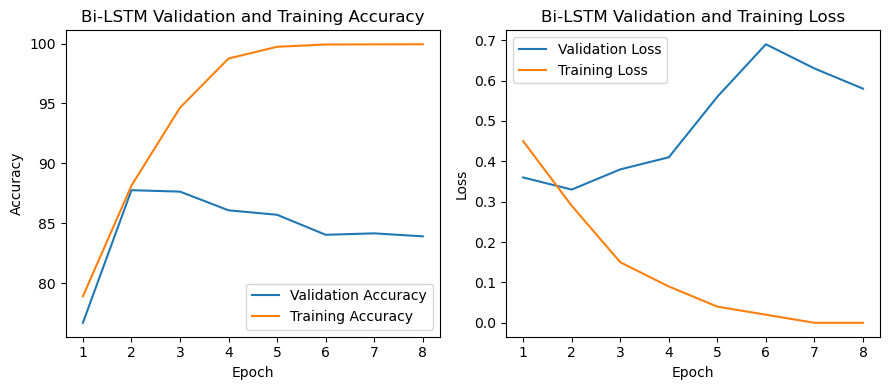

In [62]:
epochs_8 = list(range(1, 9))
accuracies_8 = [76.71, 87.77, 87.65, 86.09, 85.72, 84.05, 84.17, 83.92]
losses_8 = [0.36, 0.33, 0.38, 0.41, 0.56, 0.69, 0.63, 0.58]
train_accuracies_8 = [78.92, 88.15, 94.65, 98.75, 99.73, 99.92, 99.93,99.94]
train_losses_8 = [0.45, 0.29, 0.15, 0.09, 0.04, 0.02, 0.00, 0.00]
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_8, accuracies_8, label='Validation Accuracy')
plt.plot(epochs_8, train_accuracies_8, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Bi-LSTM Validation and Training Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_8, losses_8, label='Validation Loss')
plt.plot(epochs_8, train_losses_8, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bi-LSTM Validation and Training Loss')
plt.legend()
plt.tight_layout()
plt.show()

### GRU MODEL - Rakshitha

In [47]:
# GRU Model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, bidirectional=True, dropout=0.5):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded)
        output = self.fc(output[:, -1, :])
        return output

In [48]:
# Used 8 epochs and rest of the parameters are same, so we can compare both LSTM, GRU model in the same bases with same resources.
hidden_dim = 128
output_dim = 1
bidirectional = True
dropout = 0.5
lr = 0.001
batch_size = 128
num_epochs = 8

In [49]:
# Spliting the dataset into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(torchcol, dataset['label'].values, test_size=0.2, stratify=dataset['label'].values, random_state = seed)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state = seed)

# Creating tensor datasets and dataloaders
train_dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

valid_dataset = TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid))
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)

test_dataset = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [50]:
# Intializing model and defining the train and validation loops.
model = GRUModel(torchsize, torchdim, hidden_dim, output_dim, bidirectional=bidirectional, dropout=dropout)
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Function to calculate accuracy
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Function to train the model
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch_text, batch_labels in iterator:
        optimizer.zero_grad()
        predictions = model(batch_text).squeeze(1)
        loss = criterion(predictions, batch_labels.float())
        acc = binary_accuracy(predictions, batch_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Function to evaluate the model
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch_text, batch_labels in iterator:
            predictions = model(batch_text).squeeze(1)
            loss = criterion(predictions, batch_labels.float())
            acc = binary_accuracy(predictions, batch_labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [46]:
# Driver function for training and validation loops
best_valid_loss = float('inf')
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
# We only saved the best epoch as our model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'GRU.pt')

    print(f'Epoch Number {epoch+1}:')    
    print(f'\tTraining Accuracy  : {train_acc*100:.2f}% Validation Accuracy  : {valid_acc*100:.2f}%')
    print(f'\tTraining Loss  : {train_loss:.2f} Validation Loss  : {valid_loss:.2f}')

Epoch Number 1:
	Training Accuracy  : 61.59% Validation Accuracy  : 64.30%
	Training Loss  : 0.64 Validation Loss  : 0.69
Epoch Number 2:
	Training Accuracy  : 76.69% Validation Accuracy  : 76.16%
	Training Loss  : 0.50 Validation Loss  : 0.63
Epoch Number 3:
	Training Accuracy  : 81.87% Validation Accuracy  : 77.73%
	Training Loss  : 0.41 Validation Loss  : 0.64
Epoch Number 4:
	Training Accuracy  : 85.01% Validation Accuracy  : 80.67%
	Training Loss  : 0.35 Validation Loss  : 0.64
Epoch Number 5:
	Training Accuracy  : 87.27% Validation Accuracy  : 82.92%
	Training Loss  : 0.30 Validation Loss  : 0.58
Epoch Number 6:
	Training Accuracy  : 88.69% Validation Accuracy  : 82.99%
	Training Loss  : 0.28 Validation Loss  : 0.65
Epoch Number 7:
	Training Accuracy  : 89.95% Validation Accuracy  : 83.68%
	Training Loss  : 0.25 Validation Loss  : 0.65
Epoch Number 8:
	Training Accuracy  : 90.83% Validation Accuracy  : 84.53%
	Training Loss  : 0.22 Validation Loss  : 0.68


In [51]:
# Load the best model using torch and evaluate on test set
model.load_state_dict(torch.load('GRU.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'GRU Accuracy: {test_acc*100:.2f}%')

GRU Accuracy: 83.27%


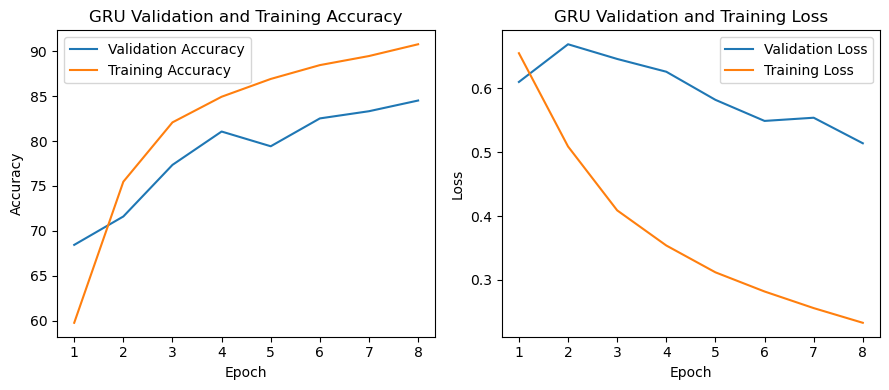

In [63]:
epochs_10 = list(range(1, 9))
accuracies_10 = [68.45, 71.61, 77.35, 81.06, 79.42, 82.52, 83.32, 84.51]
losses_10 = [0.610, 0.669, 0.646, 0.626, 0.582, 0.549, 0.554, 0.514]
train_accuracies_10 = [59.78, 75.48, 82.08, 84.93, 86.91, 88.45, 89.46, 90.77]
train_losses_10 = [0.655, 0.509, 0.409, 0.354, 0.312, 0.282, 0.256, 0.233]
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_10, accuracies_10, label='Validation Accuracy')
plt.plot(epochs_10, train_accuracies_10, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GRU Validation and Training Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_10, losses_10, label='Validation Loss')
plt.plot(epochs_10, train_losses_10, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU Validation and Training Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
# Custom movie reviews from user
custom = [
    "This movie is awesome!",
    "I really disliked this film, worst ever.",
    "The acting was superb!",
    "Not at all recommended, waste of time, waste of money and headache.",
    "My first exposure to the Templarios & not a good one. I was excited to find this title among the offerings from Anchor Bay Video, which has brought us other cult classics such as 'Spider Baby'. The print quality is excellent, but this alone can't hide the fact that the film is deadly dull. There's a thrilling opening sequence in which the villagers exact a terrible revenge on the Templars (& set the whole thing in motion), but everything else in the movie is slow, ponderous &, ultimately, unfulfilling. Adding insult to injury: the movie was dubbed, not subtitled, as promised on the video jacket."
]

In [54]:
# NLP pre-processing the reviews and not data cleaning!
preprocessed_statement = [NLPpreprocess(statement) for statement in custom]
tokenized_statement = [tokenizer(statement) for statement in preprocessed_statement]
sequences = [torch.tensor([lex[word] for word in statement if word in lex]) for statement in tokenized_statement]
final_statement = pad_sequence(sequences, batch_first = True, padding_value = torchlen)

In [61]:
model.eval()
with torch.no_grad():
    predictions = model(final_statement)
    
rounded_predictions = torch.round(torch.sigmoid(predictions)).squeeze(1)
sentiments = ['positive' if pred == 1 else 'negative' for pred in rounded_predictions]

for statement, sentiment in zip(custom, sentiments):
    print(f"Review: {statement}\nSentiment: {sentiment}\n---------------------------------------------------------------------------")

Review: This movie is awesome!
Sentiment: positive
---------------------------------------------------------------------------
Review: I really disliked this film, worst ever.
Sentiment: negative
---------------------------------------------------------------------------
Review: The acting was superb!
Sentiment: positive
---------------------------------------------------------------------------
Review: Not at all recommended, waste of time, waste of money and headache.
Sentiment: negative
---------------------------------------------------------------------------
Review: My first exposure to the Templarios & not a good one. I was excited to find this title among the offerings from Anchor Bay Video, which has brought us other cult classics such as 'Spider Baby'. The print quality is excellent, but this alone can't hide the fact that the film is deadly dull. There's a thrilling opening sequence in which the villagers exact a terrible revenge on the Templars (& set the whole thing in mot

References:


1. https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/input - DataSet
2. https://www.kaggle.com/code/affand20/imdb-with-pytorch
3. https://pytorch.org/docs/stable/index.html -PyTorch all Documentation